Ridge Regression Model Error: 0.127337346687
Lasso Regression Model Error: 0.12314421091


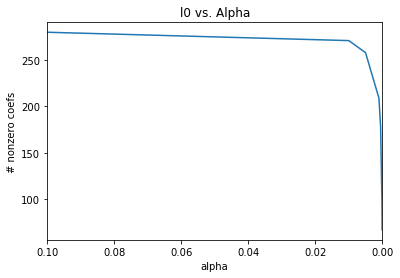

/Users/anthonydepalatis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/anthonydepalatis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Ensemble Ridge Regression Model Error: 0.127412121366


In [77]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
#import xgboost as xgb

from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.cross_validation import cross_val_score
from scipy.stats import skew

''' Helper function for calculating RMSE '''
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

''' Pre-processing '''
train = pd.read_csv('/Users/anthonydepalatis/Documents/School/EE379K/Lab4/train.csv')
test = pd.read_csv('/Users/anthonydepalatis/Documents/School/EE379K/Lab4/test.csv')
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

# Log transform the classification set
train["SalePrice"] = np.log1p(train["SalePrice"])
prices = pd.DataFrame(train["SalePrice"])

# Log transform skewed numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# Convert categorical features into dummy variables
all_data = pd.get_dummies(all_data)

# Fill NaN's with the mean of the column
all_data = all_data.fillna(all_data.mean())

# Create matrices for sklearn
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

''' Part 2 '''
# Train a ridge regression model
my_alphas = [0.01, 0.05, 0.1, 0.5, 1, 2, 4, 8, 10, 15, 30, 45, 60]
model_ridge = [rmse_cv(Ridge(alpha=alpha, solver='svd', tol=0.001)).mean() for alpha in my_alphas]
model_ridge = pd.Series(model_ridge, index = my_alphas)
print 'Ridge Regression Model Error: ' + str(model_ridge.min())

# Train a lasso regression model
my_alphas = [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
model_lasso = LassoCV(alphas=my_alphas).fit(X_train, y)
lasso_predictions = model_lasso.predict(X_test)
print 'Lasso Regression Model Error: ' + str(rmse_cv(model_lasso).mean())

''' Part 3 '''
# Get the total nonzero coefficients output by the lasso model for each alpha value
coefs = []
coefs_sums = []
for alpha in my_alphas:
    model_lasso = Lasso(alpha=alpha).fit(X_train, y)
    coef = pd.Series(model_lasso.coef_, index=X_train.columns)
    coefs.append(coef)
    coefs_sums.append(sum(coef == 0))

# Plot the number of nonzero coefficients vs. alpha
l_0 = pd.Series(coefs_sums, index = my_alphas)
l_0.plot(title="l0 vs. Alpha")
plt.xlabel("alpha")
plt.ylabel("# nonzero coefs")
plt.show()

''' Part 4 '''
# Calculate the predictions for the Ridge model with the least error
test_ridge = Ridge(alpha=10, solver='svd', tol=0.001).fit(X_train, y)
ridge_predictions = test_ridge.predict(X_test)

# Append the models' predictions to the training set and replace NaN's
X_train['Ridge Predictions'] = pd.Series(ridge_predictions, index=X_test.index)
X_train['Lasso Predictions'] = pd.Series(lasso_predictions, index=X_test.index)
X_train = X_train.fillna(X_train.mean())

# Train the ensemble model
my_alphas = [0.01, 0.05, 0.1, 0.5, 1, 2, 4, 8, 10, 15, 30, 45, 60]
ensemble = [rmse_cv(Ridge(alpha=alpha, solver='svd', tol=0.001)).mean() for alpha in my_alphas]
ensemble = pd.Series(ensemble, index = my_alphas)
print 'Ensemble Ridge Regression Model Error: ' + str(ensemble.min())